# Imports

In [2]:
import os
import csv
import numpy as np
import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import pandas as pd

from timeit import default_timer as timer
import joblib

import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Libs options

In [41]:
#np.set_printoptions(threshold=16)
pp = pprint.PrettyPrinter(indent=4, width=90)

# Dataset

In [27]:
def list_first_val(arr):
    for i in arr:
        if i > 0:
            return 1
    return -1

def get_aabb2D(data):
    """aligned-axis bounding-box (bounding square)"""
    x1 = 0xffff
    y1 = 0xffff
    x2 = 0
    y2 = 0
    # y1
    for j in range(len(data)):
        if list_first_val(data[j]) > 0:
            y1 = j
            break
    # y2
    for j in range(len(data)):
        end = len(data)-j-1
        if list_first_val(data[end]) > 0:
            y2 = end
            break
    # x1, x2
    for j in range(len(data)):
        ydata = data[j]
        val = 0xffff
        last = 0
        for i in range(len(ydata)):
            if ydata[i] > 0:
                x1 = min(x1,i)
                x2 = max(x2,i)
    return (x1,y1, x2+1,y2+1)
    
def get_X_aabb2D(X):
    aabbs = []
    for i in range(len(X)):
        aabbs.append(get_aabb2D(X[i]))
        #if i > 10: break
    return aabbs

def read_aabb_csv(dir_path, filename):
    file_path = os.path.join(dir_path, filename)
    df = pd.read_csv(file_path)
    return list(df.itertuples(index=False, name=None))

def write_aabb_csv(X, dir_path, filename):
    file_path = os.path.join(dir_path, filename)
    aabb = get_X_aabb2D(X)
    df = pd.DataFrame(aabb, columns=['x1','y1','x2','y2'])
    df.to_csv(file_path, index=False)
    return aabb
    
def scaling(X_train, X_val, X_test):
    X_train_scaled = X_train / 255.
    X_val_scaled = X_val / 255.
    X_test_scaled = X_test / 255.
    return X_train_scaled, X_val_scaled, X_test_scaled

def get_data():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'dataset')
    # folder exists ?
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # load aabb
    if os.path.exists(os.path.join(dir_path, 'aabb_train.csv')):
        aabb_train = read_aabb_csv(dir_path, 'aabb_train.csv')
        aabb_test = read_aabb_csv(dir_path, 'aabb_test.csv')
        print("bounding-squares csv loaded")
    else: # or compute them (slow!)
        aabb_train = write_aabb_csv(X_train, dir_path, 'aabb_train.csv')
        aabb_test = write_aabb_csv(X_test, dir_path, 'aabb_test.csv')
        print("bounging-squares csv computed")
    #display(df_train)
    
    # add a dim: (28, 28) -> (28, 28, 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    
    # to categorical
    y_train_cat = to_categorical(y_train, num_classes=10, dtype ="uint8")
    y_test_cat = to_categorical(y_test, num_classes=10, dtype ="uint8")
    
    # split train/validation
    X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_train, y_train_cat, test_size=0.25, random_state=1)
    aabb_train, aabb_val = train_test_split(aabb_train, test_size=0.25, random_state=1)
    
    # scaling
    X_train_scaled, X_val_scaled, X_test_scaled = scaling(X_train,X_val,X_test)
    
    return (X_train, y_train),(X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(aabb_train, aabb_val, aabb_test)

            
(X_train, y_train),(X_train_scaled, y_train_cat),(X_val_scaled, y_val_cat),(X_test_scaled, y_test_cat),(aabb_train, aabb_val, aabb_test) = get_data()

#print("train/valid:", X_train.shape, y_train.shape)
#print("test:", X_test.shape, y_test.shape)

print("train:", X_train_scaled.shape, y_train_cat.shape);
print("val:", X_val_scaled.shape, y_val_cat.shape);
print("test:", X_test_scaled.shape, y_test_cat.shape);

print("aabb_train:", aabb_train[0]);
print("aabb_val:", aabb_val[0]);
print("aabb_test:", aabb_test[0]);

bounding-squares csv loaded
train: (45000, 28, 28, 1) (45000, 10)
val: (15000, 28, 28, 1) (15000, 10)
test: (10000, 28, 28, 1) (10000, 10)
aabb_train: (7, 4, 21, 24)
aabb_val: (8, 5, 20, 25)
aabb_test: (6, 7, 22, 27)


In [505]:
list(X_train[0][14])

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.24705882]), array([0.96078431]), array([0.94509804]), array([0.14901961]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]

# Draw image + Bounding Box

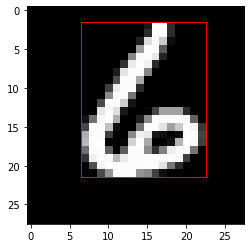

In [4]:
def plt_rectangle(tup):
    x1 = tup[0]
    y1 = tup[1]
    x2 = tup[2]
    y2 = tup[3]
    plt.gca().add_patch(Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none'))
    return


idx = 20
plt.imshow(X_train_scaled[idx], cmap='gray');
plt_rectangle(aabb_train[idx])


label is: Number 5


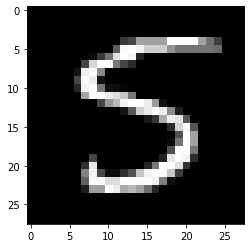

In [15]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train_scaled[item], cmap='gray');

In [9]:

def get_model(X, dropout=False):
    """ classification with 10 classes """
    model = models.Sequential()
    
    # regularizers (unused)
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    if dropout:
        model.add(layers.Dropout(rate=0.2)) # % of killed neurons (prevent overfit)
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    if dropout:
        model.add(layers.Dropout(rate=0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    return model

def get_model2(X, dropout=False):
    """ regression with 4 outputs """
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    if dropout:
        model.add(layers.Dropout(rate=0.2)) # % of killed neurons (prevent overfit)
        
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    if dropout:
        model.add(layers.Dropout(rate=0.2))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(4, activation='linear'))
    return model

model = get_model(X_train_scaled, dropout=False)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

# Train 

In [10]:

def run(model, X_train,y_train, X_val,y_val,
        opt = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        epochs = 50,
        batch_size = 16):
    
    # https://distill.pub/2017/momentum/
    # https://www.tensorflow.org/api_docs/python/tf/keras/metrics
    model.compile(optimizer=opt, 
                  loss=loss,
                  metrics=metrics)
    
    # early stopping
    es = EarlyStopping(patience = 10, restore_best_weights = True)
    
    start_time = timer()
    history = model.fit(X_train, 
                        y_train,
                        #validation_split = 0.3, # auto val generation
                        validation_data = (X_val, y_val),
                        batch_size = batch_size,
                        epochs = epochs,
                        callbacks = [es],
                        verbose = 1)
    
    training_time = timer() - start_time
    print("training time:", training_time)
    
    return history

# classification with N classes
history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat)

# regression
"""history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat,
              loss='mse',
              metrics=['mae'],
              opt=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999))"""

Epoch 1/50
2813/2813 [==============================] - 39s 13ms/step - loss: 0.2348 - accuracy: 0.9284 - val_loss: 0.1062 - val_accuracy: 0.9677
Epoch 2/50
2813/2813 [==============================] - 35s 12ms/step - loss: 0.0826 - accuracy: 0.9740 - val_loss: 0.0826 - val_accuracy: 0.9763
Epoch 3/50
2813/2813 [==============================] - 35s 12ms/step - loss: 0.0611 - accuracy: 0.9805 - val_loss: 0.0771 - val_accuracy: 0.9773
Epoch 4/50
2813/2813 [==============================] - 35s 12ms/step - loss: 0.0508 - accuracy: 0.9840 - val_loss: 0.0648 - val_accuracy: 0.9806
Epoch 5/50
2813/2813 [==============================] - 34s 12ms/step - loss: 0.0422 - accuracy: 0.9863 - val_loss: 0.0761 - val_accuracy: 0.9773
Epoch 6/50
2813/2813 [==============================] - 34s 12ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0622 - val_accuracy: 0.9829
Epoch 7/50
2813/2813 [==============================] - 35s 12ms/step - loss: 0.0313 - accuracy: 0.9904 - val_loss: 0.0713 -

"history = run(model, X_train_scaled,y_train_cat, X_val_scaled,y_val_cat,\n              loss='mse',\n              metrics=['mae'],\n              opt=optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999))"

# Plot results

In [11]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

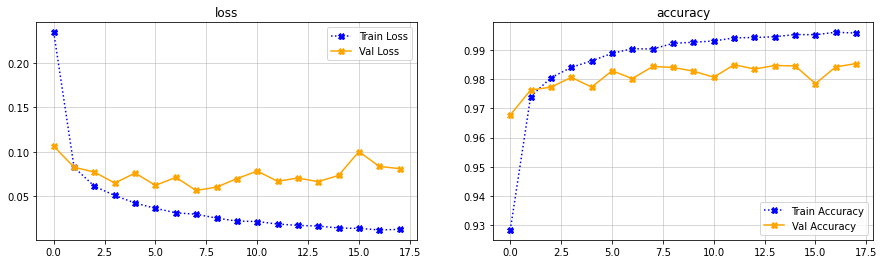

In [12]:
plot_history(history, ["loss", "accuracy"])

# Baseline Score

Zero Rate Classifier:
- https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f

In [35]:
distr = pd.Series(y_train).value_counts()
distr

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
dtype: int64

In [48]:
total = len(y_train)
baseline = ((distr / total) ** 2).sum()
print("Our baseline is: " + str(baseline*100) + "%")

Our baseline is: 10.028815944444444%


# Evaluation vs test set

In [13]:
def evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat):
    eval_res = {
        "train": model.evaluate(X_train_scaled, y_train_cat, batch_size=None, verbose = 1)[1],
        "val": model.evaluate(X_val_scaled, y_val_cat, batch_size=None, verbose = 1)[1],
        "test": model.evaluate(X_test_scaled, y_test_cat, batch_size=None, verbose = 1)[1]
    }
    return eval_res

eval_res = evaluate(X_train_scaled,y_train_cat, X_val_scaled,y_val_cat, X_test_scaled, y_test_cat)
print(f'The accuracy on the train set is of {eval_res["train"]*100:.2f} %')
print(f'The accuracy on the val set is of {eval_res["val"]*100:.2f} %')
print(f'The accuracy on the test set is of {eval_res["test"]*100:.2f} %')

313/313 [==============================] - 2s 7ms/step - loss: 0.0426 - accuracy: 0.9872
The accuracy on the train set is of 99.44 %
The accuracy on the val set is of 98.43 %
The accuracy on the test set is of 98.72 %


In [398]:
model.predict(X_test_scaled)

array([[6.5325336e-16, 6.6724130e-07, 6.5385684e-08, ..., 9.9994528e-01,
        3.0016611e-07, 6.9486015e-07],
       [1.6788428e-07, 7.1038638e-04, 9.9926776e-01, ..., 1.8594360e-08,
        1.4008916e-05, 3.4854362e-13],
       [5.8247611e-09, 9.9740124e-01, 2.0772277e-05, ..., 2.4532803e-04,
        1.5641943e-03, 1.1115384e-07],
       ...,
       [1.0115179e-18, 1.8957289e-06, 4.0689709e-09, ..., 4.1895871e-07,
        9.7220197e-07, 4.7530490e-04],
       [3.0065023e-10, 2.1965496e-12, 3.5250223e-13, ..., 4.4118809e-14,
        2.6713955e-04, 6.7136301e-07],
       [2.2947717e-10, 5.6846162e-08, 2.2614157e-13, ..., 1.4326955e-15,
        6.4021357e-08, 2.8601900e-14]], dtype=float32)

# Predict one observation

1/1 [==============================] - 0s 33ms/step


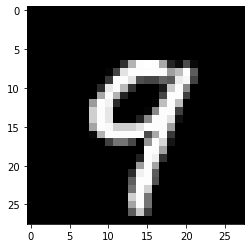

Prediction is = Number 9 (100.00%)


In [16]:
label = 12

predicted = list(model.predict(np.array([X_test_scaled[label]]))[0])
#print("prediction table:", predicted)
plt.imshow(X_test_scaled[label], cmap='gray')
plt.show()

predicted_label = labels[predicted.index(max(predicted))]
print("Prediction is =", predicted_label, f"({max(predicted)*100:.2f}%)")

# Class Scores

In [17]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

Prediction table for 'Number 9':

 [1.5553071e-11, 9.000968e-11, 2.841368e-09, 2.3864677e-06, 7.69966e-06, 1.1775229e-09, 1.2028875e-14, 1.0440984e-05, 8.06934e-07, 0.99997866]


# Save

In [19]:
def create_csv_id():
    dir_path = os.path.join(os.path.dirname(os.getcwd()), 'models')
    file_path = os.path.join(dir_path, 'ids.csv')
    cur_id = 0
    # folder exists ?
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # file exists ?
    if not os.path.exists(file_path):
        df = pd.DataFrame([0], columns=['id'])
        df.to_csv(file_path, index=False)
    else:
        # csv -> dataframe
        df = pd.read_csv(file_path)
        cur_id = df["id"].iloc[-1] + 1
        with open(file_path, "a") as f:
            csv.writer(f).writerow([cur_id])
            
    return {"cur_id": cur_id, "dir_path": dir_path}


def save_model(model):
    res = create_csv_id()
    dir_path = res["dir_path"]
    str_id = str(res["cur_id"]).zfill(4)
    base_name = f'model_{str_id}'
    
    # normal
    joblib.dump(model, os.path.join(dir_path, base_name+'.pkl'))
    
    # for tensorflow.js
    tfjs.converters.save_keras_model(model, os.path.join(dir_path, base_name))

    # for lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(os.path.join(dir_path, base_name+'.tflite'), 'wb') as f:
        f.write(tflite_model)
    return

save_model(model)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-04-25 05:14:59           64
config.json                                    2023-04-25 

/home/nes/.pyenv/versions/3.8.12/envs/BatteryProject/lib/python3.8/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


INFO:tensorflow:Assets written to: /tmp/tmp0dbj7amp/assets


INFO:tensorflow:Assets written to: /tmp/tmp0dbj7amp/assets
2023-04-25 05:15:01.506304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-25 05:15:01.506386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-04-25 05:15:01.506586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0dbj7amp
2023-04-25 05:15:01.508708: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-04-25 05:15:01.508732: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0dbj7amp
